## Lab 8. YOLO object detector

## Import libararies

In [1]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
import numpy as np
import time
import os
import cv2
import zipfile
import tarfile
from collections import namedtuple
from google.colab.patches import cv2_imshow
from xml.dom import minidom

### Download images

In [2]:
!wget "https://miro.medium.com/max/872/1*EYFejGUjvjPcc4PZTwoufw.jpeg" -O traffic.jpeg
clear_output()

### Download YOLO model

In [3]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-yolo/yolo-object-detection.zip?__s=1essnpgyhz7jwwcpjszi -O yolo-object-detection.zip
clear_output()

### Download Pascal dataset

In [4]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O pascal.tar
clear_output()

### Extract model and dataset

In [5]:
# UNZIP YOLO
with zipfile.ZipFile('yolo-object-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('yolo_data')
    
    
# UNZIP PascalVOC
if not os.path.exists('pascal'):
  os.makedirs('pascal')
tar = tarfile.open('/content/pascal.tar')
tar.extractall(path = 'pascal')
tar.close()

## IoU

In [7]:
def IoU(box1, box2):
  """
  box1: [x1,y1,x2,y2] coordinates of the ground truth box
  box2: [x1,y1,x2,y2] coordinates of the predicted box
  return: IoU between two boxes if they are overlapping, 0 otherwise
  
  with
  x1, y1:  coordinates of the upper left corner
  x2, y2: coordinates of the lower right corner
  """
  # Extract the dimensions of the first box
  box1_x_max = box1[0]
  box1_y_max = box1[1]
  box1_x_min = box1[2]
  box1_y_min = box1[3]
  # Extract the dimensions of the second box
  box2_x_max = box2[0]
  box2_y_max = box2[1]
  box2_x_min = box2[2]
  box2_y_min = box2[3]
  
  # min of max and max of min technique
  dx = min(box1_x_max, box2_x_max) - max(box1_x_min, box2_x_min)
  dy = min(box1_y_max, box2_y_max) - max(box1_y_min, box2_y_min)
  if (dx>=0) and (dy>=0):
    # determine coordinates of the intersection
    left_x = max(box1_x_min, box2_x_min)
    bottom_y = max(box1_y_min, box2_y_min)
    right_x = min(box1_x_max, box2_x_max)
    top_y = min(box1_y_max, box2_y_max)
    
    # compute intersection area
    interArea = dx*dy

    # compute the area of both the prediction and ground-truth
    # Area of box is Length * Width
    ground_area = (box1_x_max - box1_x_min) * (box1_y_max - box1_y_min)
    predicted_area = (box2_x_max - box2_x_min) * (box2_y_max - box2_y_min)

    # compute the IoU
    return interArea/(ground_area+predicted_area - interArea)
  else:
    return 0

## YOLO with OpenCV

In [8]:
PATH_TO_YOLO = 'yolo_data/yolo-object-detection/yolo-coco'
CONFIDENCE = 0.5
THRESHOLD = 0.3

class YOLO:
  def __init__(self, PATH_TO_YOLO, CONFIDENCE, THRESHOLD):
    self.CONFIDENCE = CONFIDENCE
    self.THRESHOLD = THRESHOLD
    # load the COCO class labels our YOLO model was trained on
    labelsPath = os.path.sep.join([PATH_TO_YOLO, 'coco.names'])
    self.LABELS = open(labelsPath).read().strip().split("\n")

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    self.COLORS = np.random.randint(0, 255, size=(len(self.LABELS), 3),	dtype="uint8")

    # derive the paths to the YOLO weights and model configuration
    weightsPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.weights"])
    configPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.cfg"])

    # load YOLO object detector trained on COCO dataset (80 classes)
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)#check https://docs.opencv.org/3.4.13/d6/d0f/group__dnn.html#ga351c327837e9e2d98035487695f74836
    
    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()#check https://docs.opencv.org/3.4.13/db/d30/classcv_1_1dnn_1_1Net.html#ae8be9806024a0d1d41aba687cce99e6b
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]# check https://docs.opencv.org/3.4.13/db/d30/classcv_1_1dnn_1_1Net.html#ae62a73984f62c49fd3e8e689405b056a
    
    self.net = net
    self.ln = ln
    
  def forward(self, image):
    """
    feed an image to YOLO network, filter weak boxes, 
    return boxes, confidence, class labels
    """
    (H, W) = image.shape[:2]
    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)#check https://docs.opencv.org/3.4.13/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7
    self.net.setInput(blob)
    start = time.time()
    layerOutputs = self.net.forward(self.ln)
    end = time.time()
    
    print("[INFO] YOLO took {:.6f} seconds".format(end - start))
    
    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
      # loop over each of the detections
      for detection in output:
        # extract the class ID and confidence
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions 
        if confidence > self.CONFIDENCE:
          # scale the bounding box coordinates back relative to the
          # size of the image, keeping in mind that YOLO actually
          # returns the center (x, y)-coordinates of the bounding
          # box followed by the boxes' width and height
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")

          # use the center (x, y)-coordinates to derive the top and
          # and left corner of the bounding box
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))

          # update our list of bounding box coordinates, confidences,
          # and class IDs
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)
          
    self.boxes = np.array(boxes)
    self.confidences = np.array(confidences)
    self.classIDs = np.array(classIDs)
    
  def non_max_supression(self):
    """
    perform non-maximum supression over boxes
    """
    # can be done using cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)
    idxs = np.argsort(-self.confidences)
    confidences = self.confidences[idxs]
    boxes = self.boxes[idxs]
    classIDs = self.classIDs[idxs]

    for i in range(len(boxes)):
      x,y,w,h = boxes[i][0],  boxes[i][1], boxes[i][2], boxes[i][3]
      box1 = [x, y, x+w, y+h]
      for j in range(i+1, len(boxes)):
        # If they are of the same class
        # and have a IoU above self.THRESHOLD
        # we regard them as describing the same object and
        # set the confidence of the box with lower confidence to 0
        x,y,w,h = boxes[j][0],  boxes[j][1], boxes[j][2], boxes[j][3]
        box2 = [x, y, x+w, y+h]
        if classIDs[i] == classIDs[j]:
          if IoU(box1, box2) > self.THRESHOLD:
            confidences[j] = 0

    idxs = np.where(confidences>0)
    self.boxes = boxes[idxs]
    self.confidences = confidences[idxs]
    self.classIDs = classIDs[idxs]
  
  def detect(self, image):
    """
    detect objects, supress non maximums, draw boxes
    return image with boxes
    """
    self.forward(image)
    self.non_max_supression()
    
    # draw boxes
    for i in range(len(self.boxes)):
      # extract the bounding box coordinates
      (x, y) = (self.boxes[i][0], self.boxes[i][1])
      (w, h) = (self.boxes[i][2], self.boxes[i][3])

      # draw a bounding box rectangle and label on the image
      color = self.COLORS[self.classIDs[i]].tolist()
      cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
      text = "{}: {:.4f}".format(yolo.LABELS[self.classIDs[i]], self.confidences[i])
      cv2.putText(image, text, (x, y + h - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image
  

[INFO] YOLO took 5.396919 seconds


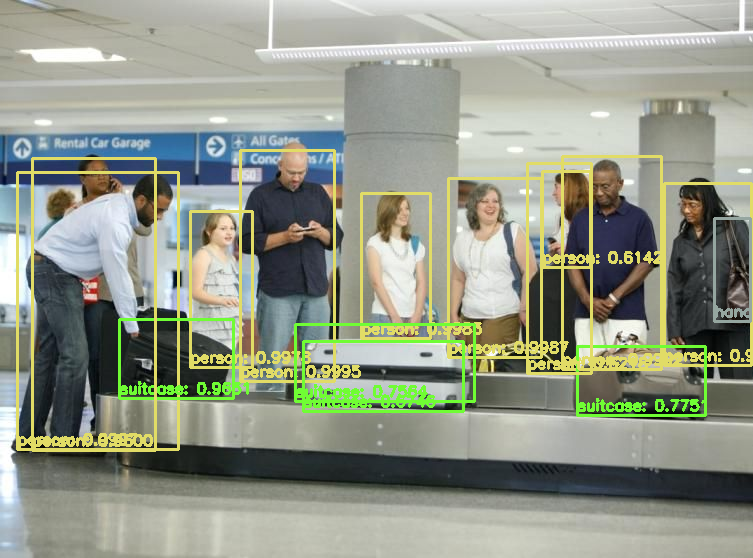

In [9]:
PATH_TO_IMAGE = 'yolo_data/yolo-object-detection/images/baggage_claim.jpg'

yolo = YOLO(PATH_TO_YOLO, CONFIDENCE, THRESHOLD)  
image = cv2.imread(PATH_TO_IMAGE)
image = yolo.detect(image)
cv2_imshow(image)

[INFO] YOLO took 2.162337 seconds


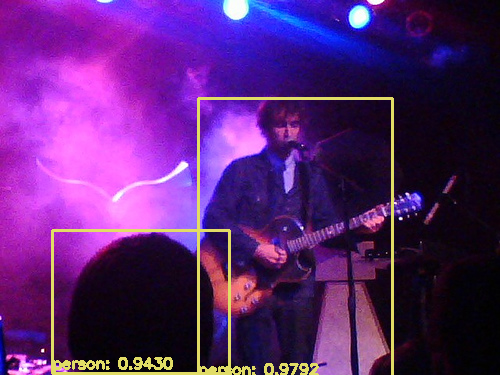

In [10]:
# print(os.listdir('/content/pascal/VOCdevkit/VOC2012/JPEGImages'))
image = cv2.imread('pascal/VOCdevkit/VOC2012/JPEGImages/2012_000160.jpg')
image = yolo.detect(image)
cv2_imshow(image)

Input image


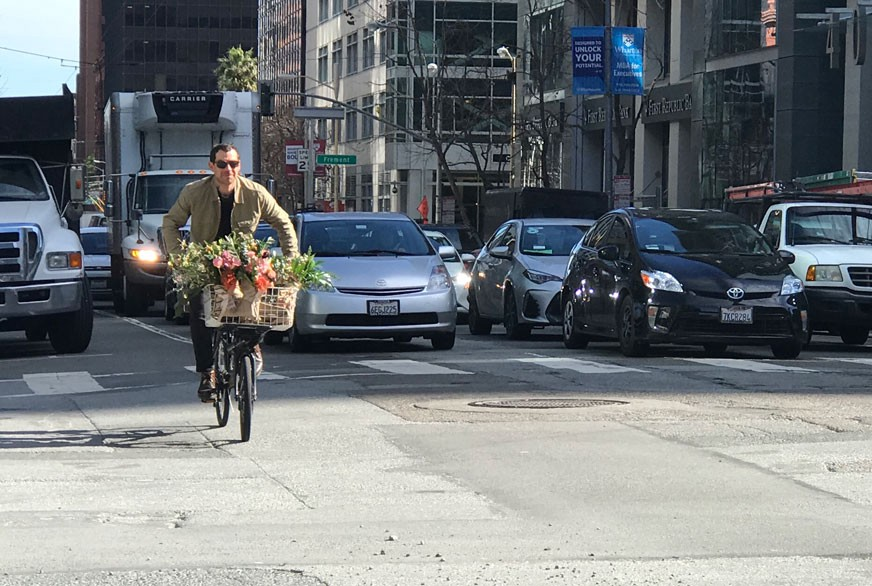

[INFO] YOLO took 2.304536 seconds
Result image


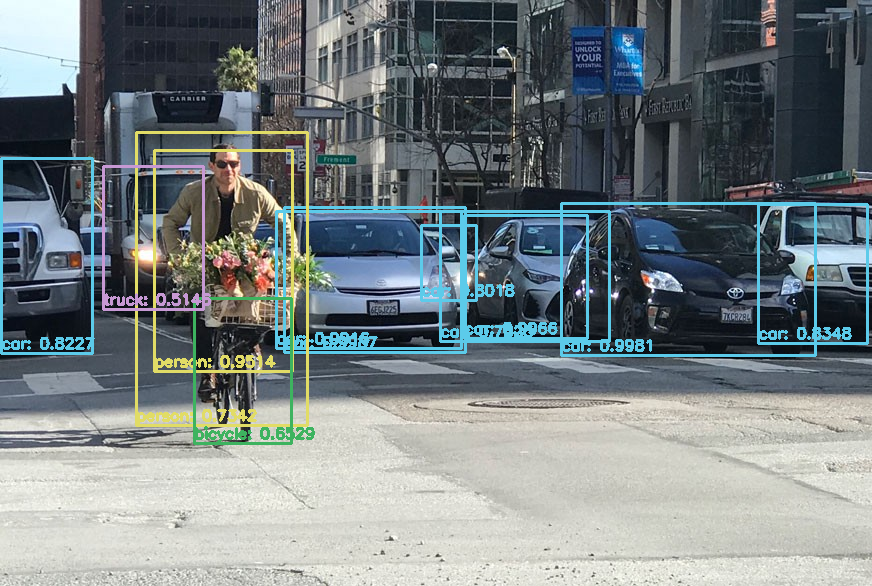

In [11]:
image = cv2.imread('traffic.jpeg')
print('Input image')
cv2_imshow(image)
image = yolo.detect(image)
print('Result image')
cv2_imshow(image)

## Mean Average Precision

In [12]:
def average_precision(precision, recall):
  AP, MAP = 0, 0
  # transform precision
  unique_recall = np.unique(recall)
  for i in range(1, len(unique_recall)):
    r = unique_recall[i]
    idx = np.where(recall == r)
    AP += (r-unique_recall[i-1]) * np.max(precision[idx])
  
  return AP

def mean_average_precision(pred_boxes, ground_truth_boxes):
  """
  
  """
  pred_box, pred_class, pred_confidence = pred_boxes[0], pred_boxes[1], pred_boxes[2]
  gt_box = ground_truth_boxes[0]
  
  # we will calculate AP for each class, hence we need
  # to calculate precision and recall for each class
  AP_class = {}
  
  # first rank predictions by their confidence
  idxs = np.argsort(pred_confidence)
  pred_box, pred_class, pred_confidence = pred_box[idxs], pred_class[idxs], pred_confidence[idxs]
  gt_box = gt_box[idxs]
  
  unique_classes = np.unique(pred_class)
  
  # calculate AP for each class
  for c in unique_classes:
    # take data for that class only
    idxs = np.where(pred_class == c)
    pb_boxes = pred_box[idxs]
    gt_boxes = gt_box[idxs]
    
    TP = FP = 0
    Precision = []
    Recall = []
    
    for pb, gt in zip(pb_boxes, gt_boxes):
      x,y,w,h = pred_box[i][0],  pred_box[i][1], pred_box[i][2], pred_box[i][3]
      box1 = [x-w/2, y+h/2, x+w/2, y-h/2]
      x,y,w,h = gt_box[i][0],  gt_box[i][1], gt_box[i][2], gt_box[i][3]
      box2 = [x-w/2, y+h/2, x+w/2, y-h/2]
      
      if IOU(box1, box2) > 0.5:
          TP =TP+1
      else:
          FP =FP+1    
      try:
          Pre = TP/(TP+FP)
          Rec = TP/len(idxs)
      except ZeroDivisionError:
          Pre = Rec = 0.0
      
      Precision.append(Pre)
      Recall.append(Rec)
      
    # now calculate the AP for that class
    AP = average_precision(Precision, Recall)
    AP_class[c] = AP
    MAP += AP

  # now after we computed AP for each class we can calculate MAP 
  return MAP/len(unique_classes)

## Comparing Detection and Annotation

Input image


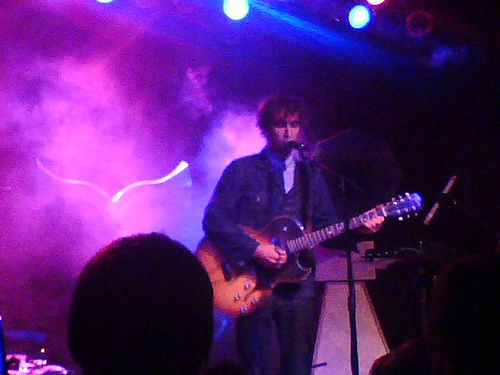

Detection
[INFO] YOLO took 2.157243 seconds


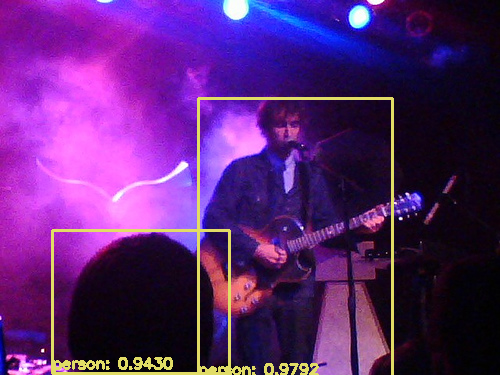

In [13]:
image = cv2.imread('pascal/VOCdevkit/VOC2012/JPEGImages/2012_000160.jpg')
print('Input image')
cv2_imshow(image)
print('Detection')
image = yolo.detect(image)
cv2_imshow(image)

#Annotations

In [14]:
os.listdir('/content/pascal/VOCdevkit/VOC2012/Annotations')
mydoc = minidom.parse('pascal/VOCdevkit/VOC2012/Annotations/2012_000160.xml')
pretty_xml_as_string = mydoc.toprettyxml()
print(pretty_xml_as_string)
items = mydoc.getElementsByTagName('object')
for elem in items:
    print(elem.getElementsByTagName('xmax')[0].firstChild.data)

<?xml version="1.0" ?>
<annotation>
	
	
	<filename>2012_000160.jpg</filename>
	
	
	<folder>VOC2012</folder>
	
	
	<object>
		
		
		<name>person</name>
		
		
		<actions>
			
			
			<jumping>0</jumping>
			
			
			<other>0</other>
			
			
			<phoning>0</phoning>
			
			
			<playinginstrument>1</playinginstrument>
			
			
			<reading>0</reading>
			
			
			<ridingbike>0</ridingbike>
			
			
			<ridinghorse>0</ridinghorse>
			
			
			<running>0</running>
			
			
			<takingphoto>0</takingphoto>
			
			
			<usingcomputer>0</usingcomputer>
			
			
			<walking>0</walking>
			
		
		</actions>
		
		
		<bndbox>
			
			
			<xmax>387</xmax>
			
			
			<xmin>201</xmin>
			
			
			<ymax>375</ymax>
			
			
			<ymin>97</ymin>
			
		
		</bndbox>
		
		
		<difficult>0</difficult>
		
		
		<pose>Unspecified</pose>
		
		
		<point>
			
			
			<x>282</x>
			
			
			<y>184</y>
			
		
		</point>
		
	
	</object>
	
	
	<segmented>0</segmented>
	
	
	<size>
		
		
		<depth>3</depth>
		
		
		<height>375</height>
		
		
	

## References

Original YOLO paper [link](https://arxiv.org/pdf/1506.02640.pdf)

YOLOv2 paper [link](https://arxiv.org/pdf/1612.08242v1.pdf)

YOLO explained [link](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)

IoU [link](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

Non-Maximum Supression [link](https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/)

Overview of deep learning based object detection approaches [link](https://towardsdatascience.com/beginners-guide-to-object-detection-algorithms-6620fb31c375)

Mean Average Precision [link](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)

YOLO using OpenCV [link](https://docs.opencv.org/master/da/d9d/tutorial_dnn_yolo.html)

Deep learning using OpenCV [link](https://docs.opencv.org/master/d2/d58/tutorial_table_of_content_dnn.html)

Blob from image [link](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/)

